# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [22]:
# Import libraries
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [23]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype)
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype)
I = torch.eye(2, dtype=exp_dtype)

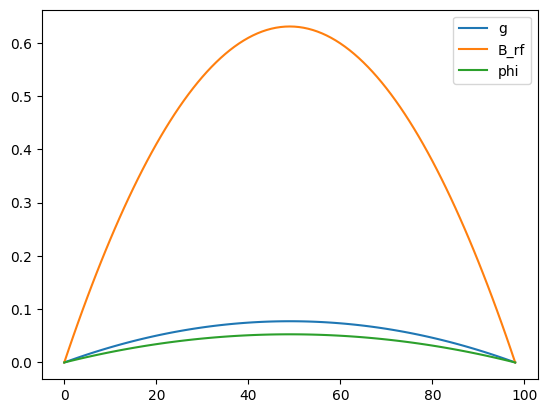

In [24]:
# Dice up the time
Ti, Tf = 0, 1
dt = 0.01
M = int((Tf - Ti) // dt)
t = np.arange(M) 

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 1
kB = 1.38e-23 # J/K
Te = 0.1 # Electron temp
f_rf = 1e9 # Hz
w_rf = 2 * np.pi * f_rf
w = 2 * muB * B0 / hbar
w_rf = w

# w = 1
# w_rf = 1
# muB = 1
# hbar = 1
# B0 = 1

# Define control parameters
g = np.zeros(M)
B_rf = np.zeros(M) 
phi = np.zeros(M)
J = np.zeros(M)

# Interpolate to give it some shape
interp_step = M // 2
scale = 10

g[::interp_step] = np.random.rand(M // interp_step + 1) / scale
g[0] = 0
g[-1] = 0
B_rf[::interp_step] = np.random.rand(M // interp_step + 1) 
B_rf[0] = 0
B_rf[-1] = 0
phi[::interp_step] = np.random.rand(M // interp_step + 1) / scale
phi[0] = 0
phi[-1] = 0
# J[::interp_step] = np.random.rand(M // interp_step + 1) / scale

g_cs  = CubicSpline(t[::interp_step], g[::interp_step])
B_rf_cs = CubicSpline(t[::interp_step], B_rf[::interp_step])
phi_cs = CubicSpline(t[::interp_step], phi[::interp_step])
# J_cs = CubicSpline(t[::interp_step], J[::interp_step])

g[:] =  g_cs(t)
B_rf[:] =  B_rf_cs(t)
phi[:] =  phi_cs(t)
# J[:] =  J_cs(t)
# print(B_rf)

plt.plot(g, label="g")
plt.plot(B_rf, label="B_rf")
plt.plot(phi, label="phi")
plt.legend(loc="best")
# plt.plot(J)
plt.show()

# Convert to optimization variables with torch properties
g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)
J = Variable(torch.tensor(J, dtype=exp_dtype), requires_grad=True)


In [25]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)

# Define Lindblad operators
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up
T1 = 1e-3
T2 = 1e-6

L1 = np.sqrt(P_up / (2 * T1)) * sigma_plus
L2 = np.sqrt(P_down / (2 * T1)) * sigma_minus
L3 = sigma_z / (2 * np.sqrt(T2))

L = [L1, L2, L3]

L_total = torch.zeros(4, 4, dtype=exp_dtype)
for i in range(len(L)):
    L_total += 2 * kron(L[i], torch.conj(L[i])) - kron(torch.matmul(hermitian_conj(L[i]), L[i]), I) - kron(I, torch.matmul(L[i].transpose(0,1), torch.conj(L[i])))

In [26]:
# Construct superoperator
def L_F(g, B_rf, phi, J, L):
    dispersive = False
    H_rf = torch.zeros((M, 2, 2), dtype=exp_dtype)
    Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
    for i in range(M):
        H_rf[i] = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]).item() * sigma_x + torch.sin(phi[i]).item() * sigma_y)
        Gamma[i] = -1j * (kron(H_rf[i], I) - kron(I, H_rf[i].transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf[i], I) - kron(I, H_rf[i].transpose(0,1)))
    Gamma_sum = torch.matrix_exp(torch.sum(Gamma * dt, dim=0))
    # return torch.prod(torch.matrix_exp(Gamma * dt), dim = 0, dtype=exp_dtype)
    return Gamma_sum

print(L_F(g, B_rf, phi, J, L))

# Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)

theta = np.pi/2
UF = RX(theta)
HF = (theta/2) * sigma_x
L_desired = -1j *(kron(HF, I) - kron(I, HF.transpose(0,1))) 
L_desired = torch.matrix_exp( L_desired )

rho0 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype)
rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho_out = torch.matmul(
            L_F(g, B_rf, phi, J, L), rho0.view(-1,)
        )
print(L_desired)

print(rho_desired.view(2,2))
print(rho_out.view(2,2))




tensor([[ 0.9928-1.1285e-07j,  0.0040-8.4317e-02j,  0.0040+8.4316e-02j,
          0.0072-6.9155e-08j],
        [-0.0031-8.4356e-02j,  0.9928+1.0361e-02j,  0.0072-6.0800e-04j,
          0.0031+8.4352e-02j],
        [-0.0031+8.4352e-02j,  0.0072+6.0725e-04j,  0.9928-1.0362e-02j,
          0.0031-8.4356e-02j],
        [ 0.0072+9.4272e-08j, -0.0040+8.4316e-02j, -0.0040-8.4317e-02j,
          0.9928+2.0697e-07j]], dtype=torch.complex128,
       grad_fn=<LinalgMatrixExpBackward0>)
tensor([[0.5000+0.0000j, 0.0000+0.5000j, 0.0000-0.5000j, 0.5000+0.0000j],
        [0.0000+0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000-0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j, 0.5000+0.0000j, 0.0000+0.5000j],
        [0.5000+0.0000j, 0.0000-0.5000j, 0.0000+0.5000j, 0.5000+0.0000j]],
       dtype=torch.complex128)
tensor([[0.5000+0.0000j, 0.0000+0.5000j],
        [0.0000-0.5000j, 0.5000+0.0000j]], dtype=torch.complex128)
tensor([[ 0.9928-1.1285e-07j, -0.0031-8.4356e-02j],
        [-0.0031+8.4352e-02j,  

In [32]:

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def forward(self, output, target, params):
        criterion = torch.nn.L1Loss()

        penalty_start_stop = 1
        cost_start_stop = 0
        for param in params:
            cost_start_stop += penalty_start_stop * torch.sum(torch.square(torch.abs(param[0])) + torch.square(torch.abs(param[-1]))).real

        return criterion(output, target) + cost_start_stop
    
opt_params = [g, B_rf, phi]
print(opt_params)
optimizer = torch.optim.Adam(opt_params, lr =0.075)
criterion = CostFunction()

epochs = 1500
loss_array = []
for i in range(epochs):
    optimizer.zero_grad()
    L_output = L_F(g, B_rf, phi, J, L)
    loss = criterion(L_output, L_desired, opt_params)
    loss.backward()
    optimizer.step()
    loss_array.append(loss.item())
    if i % 25 == 0:
        print(L_output)
        print("Step {}: Loss = {}".format(i, loss.item()))
        
print(L_output, L_desired)

plt.plot(range(epochs), loss_array)
plt.show()
plt.plot(g.detach().numpy(), label="g")
plt.plot(B_rf.detach().numpy() , label = "B_rf")
plt.plot(phi.detach().numpy(), label = "phi")
plt.legend(loc='best')
plt.show()

rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )

print(rho_out.view(2,2))

    

[tensor([nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan

KeyboardInterrupt: 